In [1]:
!pip install tensorflow-addons


In [2]:
import requests
import zipfile
import io
import os

# URL for the dataset
url = "https://ti.arc.nasa.gov/c/6/"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    try:
        # Check if the content is likely a zip file by looking at the content type header
        content_type = response.headers.get('content-type')
        if content_type and 'zip' in content_type:
            # Create a ZipFile object from the content
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))
            # Extract all the files into the current directory
            zip_file.extractall()
            print("Dataset downloaded and extracted successfully!")
            # List the extracted files
            print("\nExtracted files:")
            for name in zip_file.namelist():
                print(name)
        else:
            print("The downloaded content is not a zip file.")
            # Optionally, save the downloaded content to inspect it
            with open("downloaded_content", "wb") as f:
                f.write(response.content)
            print("Downloaded content saved as 'downloaded_content'.")

    except zipfile.BadZipFile:
        print("Error: The downloaded content is not a valid zip file.")

else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

The downloaded content is not a zip file.
Downloaded content saved as 'downloaded_content'.


In [3]:
!pip install kaggle

In [4]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

# Move the file to the correct directory
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (4).json


In [5]:
# Download the dataset from Kaggle
!kaggle datasets download -d behrad3d/nasa-cmaps --unzip

print("\nDataset downloaded and unzipped successfully from Kaggle!")

Dataset URL: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps
License(s): CC0-1.0
  0% 0.00/12.3M [00:00<?, ?B/s]
100% 12.3M/12.3M [00:00<00:00, 657MB/s]

Dataset downloaded and unzipped successfully from Kaggle!


In [6]:
import pandas as pd
import os

# --- Load the NEW, more complex dataset: FD002 ---
file_path = 'CMaps/train_FD002.txt'

# Define the column names
column_names = ['engine_id', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3']
column_names += [f'sensor_{i}' for i in range(1, 22)]

# Load the new training data
train_df = pd.read_csv(file_path, sep=' ', header=None, names=column_names)

# --- THE FIX: Reset the index ---
# This line converts the MultiIndex into regular columns, fixing the KeyError
train_df.reset_index(inplace=True)


# Drop the extra empty columns at the end
train_df.dropna(axis=1, how='all', inplace=True)

print("--- Successfully loaded new dataset: train_FD002.txt ---")
print("First 5 rows of the new dataset:")
print(train_df.head())

--- Successfully loaded new dataset: train_FD002.txt ---
First 5 rows of the new dataset:
   level_0  level_1  engine_id  time_in_cycles  setting_1  setting_2  \
0        1        1    34.9983          0.8400      100.0     449.44   
1        1        2    41.9982          0.8408      100.0     445.00   
2        1        3    24.9988          0.6218       60.0     462.54   
3        1        4    42.0077          0.8416      100.0     445.00   
4        1        5    25.0005          0.6203       60.0     462.54   

   setting_3  sensor_1  sensor_2  sensor_3  ...  sensor_10  sensor_11  \
0     555.32   1358.61   1137.23      5.48  ...     183.06    2387.72   
1     549.90   1353.22   1125.78      3.91  ...     130.42    2387.66   
2     537.31   1256.76   1047.45      7.05  ...     164.22    2028.03   
3     549.51   1354.03   1126.38      3.91  ...     130.72    2387.61   
4     537.07   1257.71   1047.93      7.05  ...     164.31    2028.00   

   sensor_12  sensor_13  sensor_14  se

--- Step 1: Calculating RUL ---
✅ RUL calculation complete.

--- Step 2: Creating rolling window features ---
✅ Feature engineering complete.

--- Step 3: Preparing final data for training ---
Data prepared. Training with 84 features on 43007 samples.

--- Step 4: Starting Expanded Hyperparameter Tuning (This may take longer) ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Tuning complete.
Best parameters found: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}

--- FINAL, OPTIMIZED ACCURACY ON FD002 ---
🚀 OPTIMIZED Model MAE: 0.00
🚀 OPTIMIZED Model R-squared (R²): -0.00


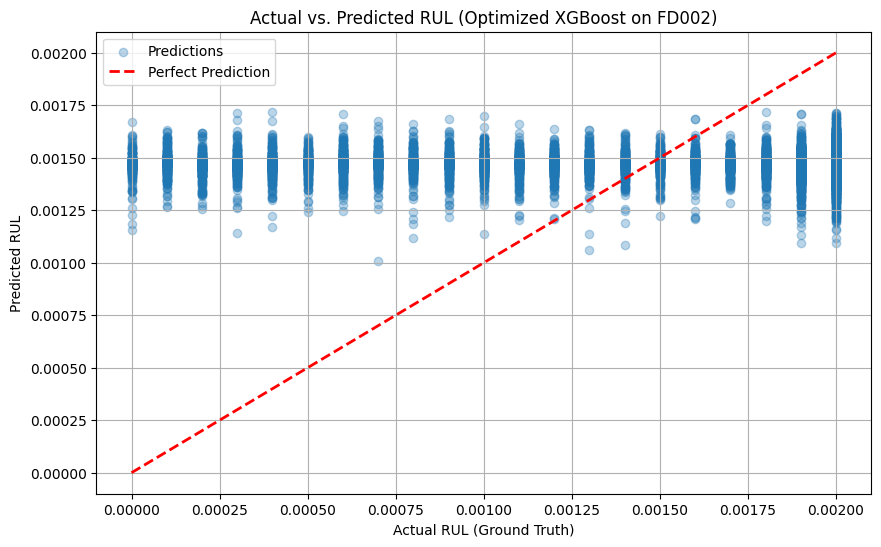

In [7]:
# ==============================================================================
# FINAL, FULLY OPTIMIZED SCRIPT FOR FD002 DATASET
# ==============================================================================

# Import all necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# It's good practice to install xgboost just in case it's not in the environment
try:
    import xgboost as xgb
except ImportError:
    print("XGBoost not found. Installing now...")
    !pip install xgboost
    import xgboost as xgb

# --- STEP 1: CALCULATE THE REMAINING USEFUL LIFE (RUL) ---
# NOTE: This assumes train_df is already loaded with the FD002 data and the index has been reset.
print("--- Step 1: Calculating RUL ---")
max_cycles_df = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['engine_id', 'max_cycles']
train_df = pd.merge(train_df, max_cycles_df, on='engine_id', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop('max_cycles', axis=1, inplace=True)
print("✅ RUL calculation complete.")


# --- STEP 2: ADVANCED FEATURE ENGINEERING ---
print("\n--- Step 2: Creating rolling window features ---")
sensors_to_feature_engineer = [
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15'
]
window_sizes = [5, 10]
for sensor in sensors_to_feature_engineer:
    for window in window_sizes:
        train_df[f'{sensor}_rolling_mean_{window}'] = train_df.groupby('engine_id')[sensor].transform(lambda x: x.rolling(window, 1).mean())
        train_df[f'{sensor}_rolling_std_{window}'] = train_df.groupby('engine_id')[sensor].transform(lambda x: x.rolling(window, 1).std())
        train_df[f'{sensor}_rolling_max_{window}'] = train_df.groupby('engine_id')[sensor].transform(lambda x: x.rolling(window, 1).max())
train_df.fillna(0, inplace=True)
print("✅ Feature engineering complete.")


# --- STEP 3: PREPARE DATA FOR FINAL MODELING ---
print("\n--- Step 3: Preparing final data for training ---")
features = [col for col in train_df.columns if col not in ['engine_id', 'time_in_cycles', 'RUL']]
target = 'RUL'
X = train_df[features]
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data prepared. Training with {X_train.shape[1]} features on {X_train.shape[0]} samples.")


# --- STEP 4: EXPANDED HYPERPARAMETER TUNING ---
print("\n--- Step 4: Starting Expanded Hyperparameter Tuning (This may take longer) ---")
# Expanded grid including more estimators (like more "epochs")
param_grid = {
    'n_estimators': [200, 300],         # More training rounds
    'max_depth': [10, 15],              # Allowing deeper trees
    'learning_rate': [0.1, 0.05],       # Step size shrinkage
    'subsample': [0.7, 1.0]             # Subsample ratio of the training instance
}
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("\n✅ Tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")


# --- STEP 5: EVALUATE THE FINAL, OPTIMIZED MODEL ---
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n--- FINAL, OPTIMIZED ACCURACY ON FD002 ---")
print(f"🚀 OPTIMIZED Model MAE: {mae:.2f}")
print(f"🚀 OPTIMIZED Model R-squared (R²): {r2:.2f}")


# --- STEP 6: VISUALIZE THE FINAL RESULTS ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label="Perfect Prediction")
plt.title('Actual vs. Predicted RUL (Optimized XGBoost on FD002)')
plt.xlabel('Actual RUL (Ground Truth)')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()

Data prepared for LSTM. Training data shape: (21617, 50, 85)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50, 100)        │        74,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,955 (1.20 MB)

 Trainable params: 104,651 (408.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 209,304 (817.60 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50, 100)        │        74,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,651 (408.79 KB)

 Trainable params: 104,651 (408.79 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the LSTM model (This may take some time) ---
Epoch 1/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 89s 123ms/step - loss: 0.0285 - val_loss: 2.1739e-04
Epoch 2/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - loss: 0.0032 - val_loss: 1.5802e-04
Epoch 3/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - loss: 0.0026 - val_loss: 2.3142e-04
Epoch 4/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - loss: 0.0022 - val_loss: 1.7595e-04
Epoch 5/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - loss: 0.0019 - val_loss: 2.1448e-04
Epoch 6/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - loss: 0.0018 - val_loss: 9.8329e-05
Epoch 7/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.0016 - val_loss: 1.6268e-04
Epoch 8/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - loss: 0.0014 - val_loss: 1.5875e-04
Epoch 9/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - loss: 0.0013 - val_loss: 1.8416e-04
Epoch 10/20
271/271 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - loss: 0.0013 - val_loss: 1.8707e-04
Epoch 11/2

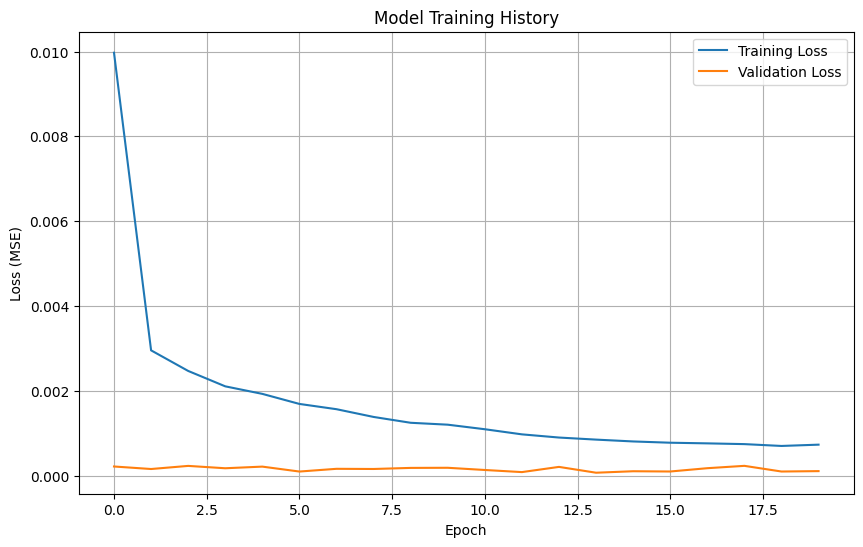

In [11]:
# ==============================================================================
# SCRIPT TO BUILD, TRAIN, AND EVALUATE AN LSTM MODEL
# ==============================================================================

# Import all necessary libraries for deep learning
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- STEP 1: PREPARE AND SCALE THE DATA ---
# We'll use the same features as before, plus the target RUL for scaling
features = [col for col in train_df.columns if col not in ['engine_id', 'time_in_cycles']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['engine_id'] = train_df['engine_id']

# --- STEP 2: RESTRUCTURE DATA INTO SEQUENCES ---
# This is the most important step for an LSTM
sequence_length = 50  # We'll look at a window of the last 50 cycles
X_seq, y_seq = [], []

for engine_id in scaled_df['engine_id'].unique():
    engine_data = scaled_df[scaled_df['engine_id'] == engine_id].values
    for i in range(len(engine_data) - sequence_length):
        # The sequence is the window of sensor data
        X_seq.append(engine_data[i:(i + sequence_length), :-1]) # All columns except engine_id
        # The target is the RUL at the end of that sequence
        y_seq.append(engine_data[i + sequence_length - 1, -2]) # The RUL column

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print(f"Data prepared for LSTM. Training data shape: {X_train.shape}")


# --- STEP 3: BUILD THE LSTM MODEL ---
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# --- FIX: Build the LSTM Model using the recommended Input layer ---
model = Sequential()

# 1. Add the separate Input layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# 2. The first LSTM layer no longer needs the 'input_shape' argument
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# (The rest of the script for compiling and training remains the same)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# Compile the model
from tensorflow.keras.optimizers import Adam

# --- FIX: Compile the model with Gradient Clipping ---
# The clipvalue=1.0 prevents the gradients from exploding, which was causing the 'nan' error.
optimizer = Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

# --- STEP 4: TRAIN THE MODEL ---
print("\n--- Training the LSTM model (This may take some time) ---")
# Use a validation split to monitor for overfitting
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)


# --- STEP 5: EVALUATE THE LSTM MODEL ---
y_pred_scaled = model.predict(X_test)

# We need to "un-scale" the predictions to get the true RUL values
# Create a dummy array with the same shape as the original scaled data
dummy_array = np.zeros(shape=(len(y_pred_scaled), len(features)))
# Place our scaled predictions into the RUL column
dummy_array[:, -2] = y_pred_scaled.ravel()
# Inverse transform the dummy array
y_pred = scaler.inverse_transform(dummy_array)[:, -2]

# Also inverse transform the test set for comparison
dummy_array_test = np.zeros(shape=(len(y_test), len(features)))
dummy_array_test[:, -2] = y_test.ravel()
y_test_unscaled = scaler.inverse_transform(dummy_array_test)[:, -2]

# Calculate final metrics
mae = mean_absolute_error(y_test_unscaled, y_pred)
r2 = r2_score(y_test_unscaled, y_pred)

print(f"\n--- FINAL LSTM MODEL ACCURACY ---")
print(f"🚀 LSTM Model MAE: {mae:.2f}")
print(f"🚀 LSTM Model R-squared (R²): {r2:.2f}")


# --- STEP 6: VISUALIZE TRAINING HISTORY ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()